In [1]:
# 1. create a Policy Network & Value Network
# Policy: MLP with (State -> Act)
# Value: MLP with (State -> 1(value))

# 2. VPGD algorithm taking Policy, Value, Envornment as input


# 3. plot loss

# *4. update to hugging face


In [18]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt
!pip install pygame ple

  Cloning https://github.com/ntasfi/PyGame-Learning-Environment.git to /private/var/folders/_t/z3tjm9014td81ypk6h_0423c0000gn/T/pip-req-build-1arjw3cc
  Running command git clone --filter=blob:none --quiet https://github.com/ntasfi/PyGame-Learning-Environment.git /private/var/folders/_t/z3tjm9014td81ypk6h_0423c0000gn/T/pip-req-build-1arjw3cc
  Resolved https://github.com/ntasfi/PyGame-Learning-Environment.git to commit 3dbe79dc0c35559bb441b9359948aabf9bb3d331
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/simoninithomas/gym-games to /private/var/folders/_t/z3tjm9014td81ypk6h_0423c0000gn/T/pip-req-build-qpdd_naz
  Running command git clone --filter=blob:none --quiet https://github.com/simoninithomas/gym-games /private/var/folders/_t/z3tjm9014td81ypk6h_0423c0000gn/T/pip-req-build-qpdd_naz
  Resolved https://github.com/simoninithomas/gym-games to commit f31695e4ba028400628dc054ee8a436f28193f0b
  Preparing metadata (setup.py) ... done


In [31]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json
import imageio

import tempfile

import os

def record_video(env, policy, out_directory, fps=30):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []
    done = False
    state = env.reset()
    img = env.render(mode="rgb_array")
    images.append(img)
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        action = take_action(policy, torch.as_tensor(state))
        state, reward, done, info = env.step(action)  # We directly put next_state = state for recording logic
        img = env.render(mode="rgb_array")
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
    
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param policy: The Reinforce agent
    """
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward

            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

def push_to_hub(repo_id,
                model,
                hyperparameters,
                eval_env,
                video_fps=30
                ):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the Hub

  :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
  :param model: the pytorch model we want to save
  :param hyperparameters: training hyperparameters
  :param eval_env: evaluation environment
  :param video_fps: how many frame per seconds to record our video replay
  """

  _, repo_name = repo_id.split("/")
  api = HfApi()

  # Step 1: Create the repo
  repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
  )

  with tempfile.TemporaryDirectory() as tmpdirname:
    local_directory = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model, local_directory / "model.pt")

    # Step 3: Save the hyperparameters to JSON
    with open(local_directory / "hyperparameters.json", "w") as outfile:
      json.dump(hyperparameters, outfile)

    # Step 4: Evaluate the model and build JSON
    mean_reward, std_reward = evaluate_agent(eval_env,
                                            hyperparameters["max_t"],
                                            hyperparameters["n_evaluation_episodes"],
                                            model)
    # Get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
          "env_id": hyperparameters["env_id"],
          "mean_reward": mean_reward,
          "n_evaluation_episodes": hyperparameters["n_evaluation_episodes"],
          "eval_datetime": eval_form_datetime,
    }

    # Write a JSON file
    with open(local_directory / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = hyperparameters["env_id"]

    metadata = {}
    metadata["tags"] = [
          env_name,
          "reinforce",
          "reinforcement-learning",
          "custom-implementation",
          "deep-rl-class"
      ]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
      )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Reinforce** Agent playing **{env_id}**
  This is a trained model of a **Reinforce** agent playing **{env_id}** .
  To learn to use this model and train yours check Unit 4 of the Deep Reinforcement Learning Course: https://huggingface.co/deep-rl-course/unit4/introduction
  """

    readme_path = local_directory / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
          readme = f.read()
    else:
      readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
      f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path =  local_directory / "replay.mp4"
    record_video(env, model, video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
          repo_id=repo_id,
          folder_path=local_directory,
          path_in_repo=".",
    )

    print(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")

# TODO
1. check performance
2. check execution time

0th iteration, p loss=-0.2828467082295286, v_loss=6.939183651822363 rewards=-5.0, std=0.0 lens=4.36

10th iteration, p loss=-0.04704764595982203, v_loss=0.9570924773694994 rewards=-4.97, std=0.1705872210923198 lens=5.92

20th iteration, p loss=0.14836423559755302, v_loss=0.4328460775031525 rewards=-2.72, std=1.9903768487399565 lens=20.21

30th iteration, p loss=0.004465760535489824, v_loss=0.8654987586335876 rewards=-1.69, std=1.6167560112769024 lens=27.16

40th iteration, p loss=0.00276843207847697, v_loss=0.6988506640351486 rewards=-0.21, std=2.6955333424018337 lens=35.87

50th iteration, p loss=-0.05073403675952527, v_loss=0.8567146079427831 rewards=-1.29, std=2.2772571220659295 lens=29.13

60th iteration, p loss=0.011990850857402277, v_loss=0.674985971246995 rewards=-0.22, std=3.1227551937351734 lens=35.72

70th iteration, p loss=0.006681607880329043, v_loss=0.5439427670241044 rewards=0.77, std=3.149142740493038 lens=41.66

80th iteration, p loss=0.009413606707845574, v_loss=0.4530

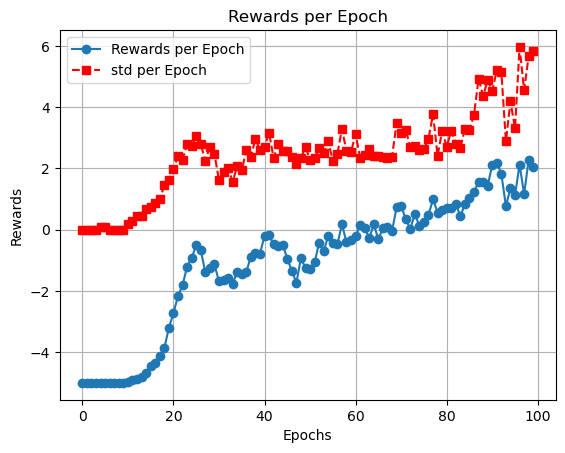

In [ ]:
# vanila policy gradient descent with reward to go and BASELINE
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import gym_pygame
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import random
import os
from datetime import datetime

# hyperparamebers to tune
learning_rate =  1e-3
gamma = 0.9

debug = False

# File path to the model
model_file_path = "model.pth"
video_fps = 30
# video_path = 'replay.mp4'


def load_model(model, model_file_path):
  # Check if the model file exists
    if os.path.exists(model_file_path):
        print(f"Loading model from {model_file_path}...")
        # Load the saved model state
        model.load_state_dict(torch.load(model_file_path))
        model.eval()  # Set the model to evaluation mode if not training further
    else:
        print(f"No saved model found at {model_file_path}. Creating a new model...")
        
def save_model(model, model_file_path):
    # Save model
    torch.save(model.state_dict(), model_file_path)

def disable_random():
    # disable all random ness
    # Set the random seed for Python's random module
    random.seed(0)
    # Set the random seed for NumPy (if you're using it)
    np.random.seed(0)
    # Set the random seed for PyTorch (CPU and GPU)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)

def print_actions(batch_abs):
    #debug if action is random enough
    if debug:
        print(f'actions: {batch_abs}')

def print_rewards(traj_rewards):
    #debug if the random actions actually yield difference in rewards
    if debug:
        print(f'traj rewards: {traj_rewards}')

class Policy(nn.Module):
    # (TODO) MLP/Policy can be reconfigured to contain multiple layers
    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 2 * dim_hidden),
            nn.ReLU(),
            nn.Linear(2 * dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_output)
        )
    # return logits of size(dim_output)
    def forward(self, x):
        return self.mlp(x)
    
class Value(nn.Module):
    # (TODO) MLP/Policy can be reconfigured to contain multiple layers
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 2 * dim_hidden),
            nn.ReLU(),
            nn.Linear(2 * dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 1)
        )
        
    def forward(self, x):
        return self.mlp(x)


# action(st), H(st) -> at based on probability distribution
def take_action(policy, s):
    logits = policy(s)
    probs = torch.softmax(logits, dim=-1)
    categorical_dist = torch.distributions.Categorical(probs = probs)
    action = categorical_dist.sample()
    return action.item()

def get_logp(policy, obs, acts):
    logits = policy(obs)
    categorical_dists = torch.distributions.Categorical(logits = logits)
    return categorical_dists.log_prob(acts)

def get_values(value, obs):
    baselines = value(obs)
    return baselines

    
# return loss, avg_reward, avg_lens for this epoch
def train_epoch(env, policy, value, num_batch, policy_opt, value_opt):
    # return [(st, at, reward, st+1, done)]
    def generate_trajectory(env, policy, num_batch):
        batch_traj = []
        for i in range(num_batch):
            st = env.reset()
            done = False
            while not done:
                action = take_action(policy, torch.tensor(st))
                st_1, reward, done, _ = env.step(action)
                batch_traj.append((st, action, reward, st_1, done))
                st = st_1
        return batch_traj
    
    # traj: [(st, at, reward, st+1, done)]
    def fit_value_evaluation(value, value_opt, batch_traj):
        targets = []
        predications = []
        for st, at, reward, st_1, done in batch_traj:
            v_st = value(torch.as_tensor(st))
            predications.append(v_st)
            if not done:
                target = reward + gamma * value(torch.as_tensor(st_1)).item()
                targets.append(target)
            else:
                targets.append(reward)
        value_opt.zero_grad()
        targets = torch.as_tensor(targets, dtype=torch.float64)
        predications = torch.stack(predications).squeeze(-1)
        loss = nn.MSELoss()(predications, targets)
        loss.backward()
        value_opt.step()
        return loss.item()
        
    
    def fit_policy_evaluation(policy, policy_opt, batch_traj, value):
        batch_adv = [] # [tensor(torch.double)]
        batch_st = []
        batch_at = []
        # compute adv(st, at)
        with torch.no_grad():
            for st, at, reward, st_1, done in batch_traj:
                v_st = value(torch.as_tensor(st)).item()
                v_st_1 = value(torch.as_tensor(st_1)).item() if not done else 0
                batch_adv.append(reward + gamma * v_st_1 - v_st)
                batch_st.append(st)
                batch_at.append(at)
        logps = get_logp(policy = policy, obs= torch.as_tensor(batch_st), acts = torch.as_tensor(batch_at))
        loss = -(logps * torch.as_tensor(batch_adv)).mean()
        policy_opt.zero_grad()
        loss.backward()
        policy_opt.step()
        return loss.item()
    
    # return mean(reward), len(reward), std(reward)
    def evaluate_policy(batch_traj):
        sampled_rewards = []
        traj_lens = []
        traj_reward = 0
        len = 0
        for st, at, reward, st_1, done in batch_traj:
            len += 1
            traj_reward += reward
            if done:
                sampled_rewards.append(traj_reward)
                traj_lens.append(len)
                traj_reward = 0
                len = 0
        return np.mean(sampled_rewards), np.std(sampled_rewards), np.mean(traj_lens)
                
        
    # start = timer()
    batch_traj = generate_trajectory(env, policy, num_batch)
    v_loss = fit_value_evaluation(value, value_opt, batch_traj)
    p_loss = fit_policy_evaluation(policy = policy, policy_opt = policy_opt, batch_traj = batch_traj, value = value)
    reward_mean, reward_std, len_mean = evaluate_policy(batch_traj)
    
    return p_loss, v_loss, reward_mean, len_mean, reward_std
def train():
    start = timer()
    #debug
    # disable_random()
    env = gym.make("Pixelcopter-PLE-v0")
    # make the action deterministic
    dim_input = env.observation_space.shape[0]
    dim_output = env.action_space.n
    policy = Policy(dim_input, 32, dim_output).double()
    value = Value(dim_input, 32).double()
    # load_model(policy, model_file_path)
    policy_opt = torch.optim.Adam(policy.parameters(), lr = learning_rate)
    value_opt = torch.optim.Adam(value.parameters(), lr = learning_rate)

    num_epoch = 200
    num_batch = 100
    rewards = []
    reward_std = []
    for i in range(num_epoch):
        p_loss, v_loss, reward, lens, reward_st = train_epoch(env, policy, value, num_batch, policy_opt, value_opt)
        if i % 10 == 0:
            print(f"{i}th iteration, p loss={p_loss}, v_loss={v_loss} rewards={reward}, std={reward_st} lens={lens}\n")
        # print(f"{i}th iteration, loss={loss}, rewards={reward}, std={reward_st} lens={lens}\n")

        rewards.append(reward)
        reward_std.append(reward_st)
    print(f'total time for traning: {timer() - start}')
    plt.plot(list(range(num_epoch)), rewards, marker='o', linestyle='-', label='Rewards per Epoch')
    plt.plot(list(range(num_epoch)), reward_std, marker='s', linestyle='--',  color='red', label='std per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Rewards')
    plt.title('Rewards per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    # save_model(policy, model_file_path)
    policy.eval()
    current_time = datetime.now()

    # Format the date and time as mm-dd-tt
    formatted_time = current_time.strftime("%m-%d-%H:%M")  # %H%M represents hours and minutes (24-hour format)

    # Append the formatted time to the string 'replay'
    video_path = f"replay-{formatted_time}.mp4"
    # record_video(env, policy, video_path, video_fps)

train()



